<div id="singlestore-header" style="display: flex; background-color: rgba(210, 255, 153, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/chart-network.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Semantic Visualization and Vector Datatype</h1>
    </div>
</div>


SingleStoreDB supports vector database processing, which allows you to store and search vector data.
Vectors usually come from objects: text, images, video, audio, etc.
In a vector space model, words with similar meanings, such as <i>"happy"</i> and <i>"joyful,"</i> are represented by vectors that lie in proximity, reflecting their semantic similarity.
Vector database searches find data based on its content or meaning, even without exact matches.

## 1. Create a workspace in your workspace group

S-00 is sufficient.

## 2. Create a database named `db_vector`

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> If you have a Free Starter Workspace deployed already, select the database from drop-down menu at the top of this notebook. It updates the <tt>connection_url</tt> to connect to that database.</p>
    </div>
</div>

In [14]:
import os
import pandas as pd
from io import StringIO

#my_file = wslib.load_data("osenv_watsonxai_singlestore.txt")
my_file = "./osenv_watsonxai_singlestore.txt"
osenv = pd.read_csv(my_file, nrows=10)

In [4]:
# Iterate through the DataFrame's rows
for index, row in osenv.iterrows():
    # Since there's no header, access the first column with index 0
    # Split the string at the first '=' to separate the key and value
    key, value = row[0].split('=', 1)
    os.environ[key] = value  # Set the environment variable

In [6]:
try:
    connection_user = os.environ["SINGLESTORE_USER"]
except KeyError:
    connection_user = getpass.getpass("Please enter your SingleStore username (hit enter): ")

In [7]:
try:
    connection_password = os.environ["SINGLESTORE_PASS"]
except KeyError:
    connection_password = getpass.getpass("Please enter your SingleStore password (hit enter): ")

In [8]:
try:
    connection_host = os.environ["SINGLESTORE_HOST"]
except KeyError:
    connection_host = input("Please enter your SingleStore database name (hit enter): ")

In [9]:
try:
    connection_port = os.environ["SINGLESTORE_PORT"]
except KeyError:
    connection_port = input("Please enter your SingleStore database name (hit enter): ")

In [10]:
try:
    database_name = os.environ["SINGLESTORE_DATABASE"]
except KeyError:
    database_name = input("Please enter your SingleStore database name (hit enter): ")

In [11]:
shared_tier_check = %sql show variables like 'is_shared_tier'
if not shared_tier_check or shared_tier_check[0][1] == 'OFF':
    %sql DROP DATABASE IF EXISTS db_vector;
    %sql CREATE DATABASE db_vector;

UsageError: Line magic function `%sql` not found.


<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> Make sure to select a database from the drop-down menu at the top of this notebook. It updates the <tt>connection_url</tt>  to connect to that database.</p>
    </div>
</div>

In [ ]:
from sqlalchemy import create_engine, text
import sqlalchemy.exc as exc
connection_url = f"singlestoredb://{connection_user}:{connection_password}@{connection_host}:{connection_port}/{database_name}"
engine = create_engine(connection_url)

NameError: name 'connection_user' is not defined

Create table `words` and insert the words into the table.

In [17]:
%%sql
CREATE TABLE words(word varchar(25));

INSERT INTO words VALUES ("red"), ("potatoes"), ("soda"), ("cheese"),
                         ("water"), ("blue"), ("crispy"), ("hamburger"),
                         ("coffee"), ("green"), ("milk"), ("la croix"),
                         ("yellow"), ("chocolate"), ("french fries"),
                         ("latte"), ("cake"), ("brown"), ("cheeseburger"),
                         ("espresso"), ("cheesecake"), ("black"), ("mocha"),
                         ("fizzy"), ("carbon"), ("banana"), ("sunshine"),
                         ("orange carrot"), ("sun"), ("hay"), ("cookies"),
                         ("fish"), ('king'), ('man'), ('woman'), ('queen'),
                         ('Paris'), ('France'), ('Poland'), ('Warsaw'),
                         ('prince'), ('throne'), ('Elizabeth'), ('ruler');

++
||
++
++

In [1]:
%%sql
SHOW TABLES EXTENDED;

UsageError: Cell magic `%%sql` not found.


## 3. Install and import required libraries
In this section, we will set up the necessary environment by installing important libraries .

The install process may take a couple minutes.

In [2]:
!pip3 install --upgrade sentence-transformers torch tensorflow pandarallel --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


Import several libraries for data manipulation (e.g., Pandas, NumPy), database connectivity (SQLAlchemy, SingleStoreDB), machine learning (PyTorch, Transformers), and parallel processing (pandarallel).

In [28]:
import json
import ibis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import singlestoredb as s2
import torch
from pandarallel import pandarallel
from transformers import AutoTokenizer
from transformers import AutoModel
from sqlalchemy import *
db_connection = create_engine(connection_url)
pandarallel.initialize(nb_workers=2, progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 4. Load Sentence Transformer model along with its tokenizer, making them ready for use in tasks like sentence embeddings or similarity calculations.

Load Sentence Transformers model

In [29]:
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## 5. Load the data into dataframe from database table

Load the data into a DataFrame

In [30]:
result = %sql  select * from words;

df = pd.DataFrame(result)
df

,word
0,milk
1,black
2,carbon
3,woman
4,Warsaw
5,green
6,la croix
7,cheeseburger
8,Poland
9,mocha


## 6. Function to retrieve the embedding

This function, named get_embedding, takes a <b>sentence</b> as input and returns its <b>embedding</b> using a pre-trained tokenizer and model. It tokenizes the sentence and returns the resulting embedding as a NumPy array with a float32 data type.

In [31]:
import numpy as np

def get_embedding(sentence: str) -> np.ndarray[np.float32]:
    """Retrieve embedding for given sentence."""
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embedding = model(**inputs).last_hidden_state.mean(dim=1).squeeze().tolist()
    return np.array(embedding, dtype='<f4')

## 7. Apply the function `get_embedding`

It adds a new column 'word_embeddings' to a DataFrame df by applying a function get_embedding in parallel to the 'word' column, aiming to calculate and store word embeddings for each word in the DataFrame. The parallel_apply function  leverages parallel processing capabilities for efficient computation.

In [32]:
# Apply the function
df['word_embeddings'] = df['word'].parallel_apply(get_embedding)

Below code writes the DataFrame df to a SQL table named `words_table` using SingleStoreDB (s2). It replaces the existing table if it already exists, does not include an index column in the table, and specifies the data type for the `word_embeddings` column as LargeBinary.

In [33]:
# Create the table with vector embeddings
df.to_sql(
    'words_table',
    s2.create_engine().connect(),
    if_exists='replace',
    index=False,
    dtype=dict(word_embeddings=sa.LargeBinary),
)

44

## 8. Visualizing words
Below code transforms word embeddings stored in the `word_embeddings` column of DataFrame df using t-SNE (t-Distributed Stochastic Neighbor Embedding), reducing the dimensionality to 2 components. The resulting transformed data is stored in the variable `vis_dims`, representing the two-dimensional visualization of the word embeddings.

In [34]:
matrix = df["word_embeddings"]
matrix = matrix.tolist()
matrix

[array([-0.19728959, -0.4110991 ,  0.11506514,  0.570162  ,  0.46950507,
         0.00291088, -0.11753931,  0.15359785,  0.04757136, -0.7595031 ,
        -0.25294203, -0.34695688, -0.65105945, -0.03078865, -0.28272292,
        -0.46689013, -0.01500004,  0.23000348,  0.2736092 ,  0.06348432,
         0.5225758 , -0.14156795, -0.18762416,  0.14887297, -0.25189614,
         0.335777  ,  0.50755584, -0.23638923, -0.07618842, -0.574344  ,
         0.36608157, -0.6630365 ,  0.35831216, -0.333195  , -0.2488507 ,
         0.27678263,  0.3714497 , -0.3260645 ,  0.47891426,  0.01890916,
         0.42326188, -0.45188376,  0.5343749 ,  0.08810223, -0.07985856,
         0.55090034, -0.64223224,  0.1488259 ,  0.45299876,  0.20113456,
         0.28313008, -0.37336597, -0.23368669, -0.01615934,  0.65789384,
         0.10424545,  0.3239635 , -0.18925142, -0.36126724,  0.31523442,
        -0.19803047,  0.08681544, -0.32220843,  0.3258505 ,  0.20921321,
         0.26411888, -0.68256825,  0.09752759, -0.2

In [35]:
matrix = np.asarray(matrix)

from sklearn.manifold import TSNE

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(44, 2)

Install the Matplotlib library using the pip package manager, allowing for the visualization of data and plots in Python.

In [36]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 129.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 16.4 MB/s eta 0:00:00


Using Matplotlib to create a scatter plot visualizing the 2D representation of word embeddings obtained from t-SNE. The code iterates through each word in the DataFrame df, extracts its coordinates from vis_dims, and annotates the corresponding point on the scatter plot with the word label. Finally, the plot is displayed using `plt.show()`.

44


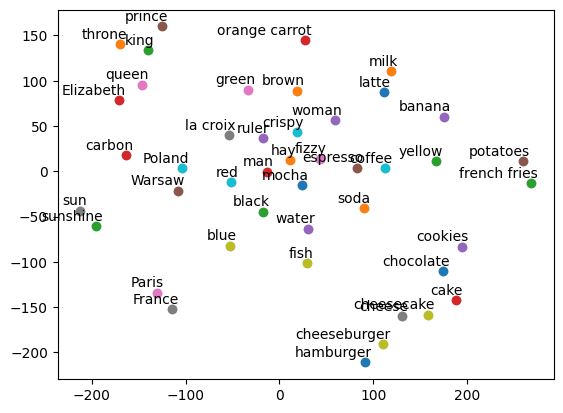

In [37]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

labels = []
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
for word in range(len(df)):
    first_value = df['word'].iat[word]
    labels.append(first_value)

print(len(df))

plt.scatter(x, y,alpha=0.3)

for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(
        labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom',
    )

plt.show();

You can insert words of your choice in the <i>  words </i> table  and execute all the cells above to visualize the semantic patterns.

## 9. Introducing Vector Datatype

We can see below `word_embeddings` column is `blob` datatype

In [38]:
%%sql
DESC words_table;

Field,Type,Null,Key,Default,Extra
word,text,YES,,None,
word_embeddings,blob,YES,,None,


In [39]:
%%sql
SELECT word, word_embeddings FROM words_table LIMIT 2;

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

This below line of code executes a SQL query on the `words_table`, selecting the `word` column and the hexadecimal representation of the `word_embeddings` column for the first row in the table using the `limit 1` clause.

In [40]:
%%sql
SELECT word, HEX(word_embeddings) FROM words_table LIMIT 1;

word,HEX(word_embeddings)
carbon,6D15A0BE181C363F94254D3E5CECAA3E610EE63D27ECCEBDDB62013EFF62AE3E98F9D2BDF5E7143FA7A15F3EDC0F1FBF356BE2BD13D70CBEF03C85BE6FD39D3E433D34BD8F158ABE3520103E58DE513D4B84B93E1B2DFF3D11EEB2BDEF918D3DD34DE8BD60C9D3BD4503F1BEF3ECA3BC6759EEBDF0F864BE2332313E60E7083EF14476BEE0D8F43D409DD93E9D550C3D07B6E9BD7DD6DFBED511ADBDC2F81FBE50AD03BEDEDDA5BE6040EC3D9D67E03C87939B3E2C7CB53DB8392B3F43C94FBEA519DE3DE2C509BFDCA7F13E93422ABD38997DBE2F89E7BED0DF60BE1D7E40BEEB872E3E7DB7E1BE2D59943C8CB649BF1025613EE4038A3D85484CBE27D5E03D0C25063F3799A0BE9D387F3EEF6279BD31CF313D7BDDA83E454134BEF16394BE0C624ABE1B3144BE4B3C91BEC504E23E6278213FF5765E3E0C1A903ED37D1BBFAB9C6B3B0BB76DBDDEE00FBE5FE890BE04807EBE5C333D3E4909C23E4B21CBBCDB36113E935554BE55657438B20F823EC278A23D5BA758BEC97ECBBB251A4B3C18A6E43ED4EF183D9368333FC8CFF83FD8627B3E9D13FD3E716980BE818C5DBE45AE9ABEE0B565BE2B20E13DF398EF3ECF32383F2042C8BE03D117BEA4A487BEBD1BB3BD6B0ED7BE2CF5F43DF88B9C3D338C8C3D60174DBEB4E4AF3E28267D3E75418ABEF16784BE3541CF3E1F8DD5BD80177A3B387881BF1FB16D3E7B6794BE2196A23D8FE9E93EF7E9883E1CCC3E3EEBAEF23D68F2FA3EDDF405BF35B81B3DE8110A3E7C99093FCDAF2CBE231D2D3EA4A11E3F2339213F0F9E1CBEBD4FB83D3F3DD9BEF9F4C5BEA31D203C180AE33C80C359BEC12592BE2B181A3F42BF893E7C02EA3DEDD5983D7B1B403F6F214EBDE1BF00BFC0695ABE40614B3F3BD1A43E2D38C8BC6713EA3E1371BEBE49D2A6BCB9BF0DBEA8DB003E13F44DBE3D4525BE085FD73E5FF2AE3D25ECE33E317712BF187C5A3EE13F78BE47FD1BBDF000D23C231CD5BE7FE70C3E88ACBD3DBDFCAF3EAD377FBE036452BE6C8762BEE3BC57BE74DECE3EB74F32BEEB9EBC3DED07C4BEEDEA15BEABDCD43E390495BDCB214BBE7CA08F3EC7612C3F03D4E3BDA401123D099E063E1C4707BF5D0D42BE701EFABE0B460D3FB41DB5BE45AF68BEA8B8833E1AD009BF43991ABFF6E9083ED452183FC4D3BFBE197724BFC97EE1BD55E16FBF0B62E2BE392284BE2F6491BDDD7976BE4DECD53EBFE6B2BDE7F313BEA0FF2DBF33FEE73E317F21BE4C626E3D7C53F3BE37B48D3E346E5D3E54584ABEB1FFEF3E4D40D73DA3ADC3BEC32F9A3D33AB523DA825103E281A373D9321D23E83E1933E14E6ADBEBA9C093E002C993D88FDC63E599A01BF3471DFBE9B8C4ABEA5E9483EB1D087BE23D8EABE910089BEEEE70B3F634E2BBEA10AD93EA6AA9FBE00F4F0BD953A0A3F23D9E9BD6BAE06BF120B223FF378D6BE4BFDA1BB3B8F1EBE0E0F26BF7D295E3EFDD2F63ED1D600BF73C6E4BE09DE99BE49D699BDCB68F23DDB7A903E90FFAA3EA53033BECD70C1BDADAD85BE218A14BF4301A0BDEC5E353FF587E83BA341743EC41E2C3E67CE853FBC4E343F211715BD37CF193F5FA2AABDADA0413EB538483EE0D642BC27231A3E51A88A3D3B1FF4BE4FFF46BEF8D36ABE8D71AD3E284344BE61514F3EF3F39CBD434F363E2B75173E80BD01BED0B6F4BD114C98BEC4BF983DE0DCF0BDC1D311BE60FDD53D10C0A1BEEBCC8DBC8005103F3C30F8BDC0B9C73E88EEECBED4B691BED5EF65BD1ECE9D3E5B5F24BC4E1385BED1209D3E4F7FB6BEF9CEC03D0842C9BCF399D8BEE7821FBD7B30003CBBF6853EC1A2073ECBADC13E9D8927BE2545E03E93F78B3E2C5F93BD8186D7BEE0D1D33E7500CFBE93EAD13DCDD6A33E918BAABD9DB7E73E29D0DC3DFD0C00BEE776913EF03E033EA5D8E3BEA35CB43D308C4DBE75D38F3E24D7A83E327F153E312DA3BC25A9C9BE03A1BA3D3756A3BE44004C3C3B04A7BCCC2723BF00702BBEA0B633BC69DB7EBE38B2AFBEEB3E7FBE001E8FBD2B1F36BE6860D63DF352A63E245316BEEC3B3CBD5F4CE43EDBA476BC9B92A1BE29028DBEF337B93D57A7BCBD21B08CBD69AF22BE9869F4BC841980BEFDE54C3EC18A853D57790EBECD2C833E64FF1ABF0049E13D2BA68B3E21A900BF954B313E291888BE


Below query extracts the `word` column and unpacks the JSON array stored in the `word_embeddings` column for the first row in the `words_table`, providing a more readable representation of the word embeddings.

In [41]:
%%sql
SELECT word, JSON_ARRAY_UNPACK(word_embeddings) FROM words_table LIMIT 1;

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 10. Transition from BLOB to Vector datatype

<p> 1. Add a new vector column to the right of the blob column.</p>
<p> 2. Update the vector column with the data from the blob column.</p>
<p> 3. Drop the blob column.</p>
<p> 4. Rename the new vector column to the old blob column name. This will ensure any previous queries will still work, or at least require fewer changes.
</p>

In [42]:
%%sql
SELECT VECTOR_NUM_ELEMENTS(word_embeddings) FROM words_table LIMIT 1;

VECTOR_NUM_ELEMENTS(word_embeddings)
384


In [44]:
%%sql
ALTER TABLE words_table ADD COLUMN emb2 vector(384) AFTER word_embeddings;
UPDATE words_table SET emb2=word_embeddings;

++
||
++
++

In [45]:
%%sql
SELECT word, emb2, JSON_ARRAY_UNPACK(word_embeddings) FROM words_table LIMIT 1;

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
%%sql
ALTER TABLE words_table DROP COLUMN word_embeddings;
ALTER TABLE words_table CHANGE emb2 word_embeddings;

++
||
++
++

In [47]:
%%sql
DESC words_table;

Field,Type,Null,Key,Default,Extra
word,text,YES,,None,
word_embeddings,"vector(384, F32)",YES,,None,


## 11. Semantic Search of the word -sunshine &#127774; using Infix Operator

Performing a semantic search for the word 'sunshine' to find contextually similar or related words and phrases based on their semantic meanings rather than exact lexical matches.

The infix operators `<*>` and `<->` can be used to  facilitate DOT_PRODUCT and EUCLIDEAN_DISTANCE operations, respectively, providing a more concise query syntax compared to using the existing built-in functions such as DOT_PRODUCT(a, b) and EUCLIDEAN_DISTANCE(a, b).

In [48]:
%%sql
SELECT word_embeddings INTO @c from words_table WHERE word LIKE 'sunshine%';
SELECT word, (@c<*>word_embeddings) AS score
    FROM words_table
    ORDER BY score desc
    LIMIT 3;

word,score
sunshine,41.25114059448242
sun,34.277835845947266
yellow,18.926977157592773


## Clean up

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> If you created a new database in your Standard or Premium Workspace, you can drop the database by running the cell below. Note: this will not drop your database for Free Starter Workspaces. To drop a Free Starter Workspace, terminate the Workspace using the UI. </p>
    </div>
</div>

In [25]:
shared_tier_check = %sql show variables like 'is_shared_tier'
if not shared_tier_check or shared_tier_check[0][1] == 'OFF':
    %sql DROP DATABASE IF EXISTS db_vector;

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>